In [1]:
# Libraries
import pandas as pd # to manipulate dataframes
import numpy as np # to resolve lineal algebra problems
import datetime as dt # to manage datetime data
import matplotlib.pyplot as plt # to plot plot our results
import seaborn as sns # to plot plot our results
from pandas_datareader import DataReader as wb # to import market data from internet
from dateutil.relativedelta import relativedelta # to manage datetime data
from scipy.optimize import minimize # to resolve optimization problems

In [2]:
# Get market data
start = dt.datetime.now() - relativedelta(years=5)
end = dt.datetime.now()
tickers = ['AAPL', 'TSLA', 'AMZN', 'FB', 'MSFT']
df = wb(tickers,'yahoo',start,end)['Close']
log_ret = np.log(df/df.shift(1)).dropna()

In [3]:
# Functions
def financials(weights=[]):
    mean = log_ret.mean() # vector of expected returns
    cov = log_ret.cov() # covariance matrix
    w = np.array(weights) # vector of weights
    ret = np.dot(mean.T,w) * 252 # annual expected return of portfolio
    std =  np.sqrt(np.dot(w.T,np.dot(cov * 252, w))) # annual expected volatility of portfolio returns
    return np.array([ret,std,ret/std]) #output

def max_sharpe(weights=[]):
    return -financials(weights)[2]

In [4]:
# Optimization inpputs
cons = {'type':'eq','fun':lambda x: np.sum(x) -1}
bnds = tuple((0,1) for x in range(len(tickers)))
weights = len(tickers) * [1./len(tickers)]
opts = minimize(max_sharpe, weights, method='SLSQP', bounds=bnds, constraints=cons)

In [5]:
# Optimization results
op_weights = list(np.round(opts.x,3))
op_ret = np.round(financials(op_weights)[0],3)
op_std = np.round(financials(op_weights)[1],3)
op_sharpe = np.round(financials(op_weights)[2],3)

# Print results
result = '\nPortfolio optimization result\n'\
        + 'Assets:  ' + str(tickers) + '\n'\
        + 'Weights: ' + str(op_weights) + '\n'\
        + '\nOptimal Return:      ' + str(op_ret) + '\n'\
        + 'Optimal volatility:  ' + str(op_std) + '\n'\
        + 'Optimal Sharpe:      ' + str(op_sharpe)

print(result)


Portfolio optimization result
Assets:  ['AAPL', 'TSLA', 'AMZN', 'FB', 'MSFT']
Weights: [0.128, 0.219, 0.06, 0.0, 0.593]

Optimal Return:      0.392
Optimal volatility:  0.288
Optimal Sharpe:      1.358


In [6]:
# Porfolio simularion
def portfolios_simulations(data,assets,numb):
    portf_ret = []
    portf_std = []
    portf_sharpe = []
    weights = []
    ret = data.mean().values
    cov = data.cov()
    df1 = pd.DataFrame(columns=assets)
    for i in range(numb):
        w = np.random.rand(len(assets))
        w = w/w.sum()
        alpha1 = np.dot(w.T,ret)*252
        alpha2 = np.sqrt(np.dot(w.T,np.dot(cov,w))*252)
        alpha3 = alpha1/alpha2
        portf_ret.append(alpha1)
        portf_std.append(alpha2)
        portf_sharpe.append(alpha3)
        weights.append(w)
    df1 = pd.DataFrame(columns=assets, data=weights)
    df2 = pd.DataFrame(columns=['Ret', 'Std', 'Sharpe'],)
    df2['Ret'] = portf_ret
    df2['Std'] = portf_std
    df2['Sharpe'] = portf_sharpe
    df = pd.concat([df1,df2],axis=1)
    return df

In [7]:
# Scaterplot of porfolios
def plot_portfolios(port,sharpe,tickers):
    opt_port = op_weights
    x = port['Std'].values
    y= port['Ret'].values
    x_op = op_std
    y_op = op_ret
    plt.figure()
    plt.scatter(x, y,c=y/x,cmap='RdYlGn')
    plt.title('Portfolio optimization | ' + str(simul) + ' simulations')
    plt.ylabel('|Annual returns|')
    plt.xlabel(
        '|Annual volatility|'\
            + '\n'+ '---------------------------'\
                + '\n' + 'Assets:  ' + str(tickers)\
                + '\n' + 'Weights: ' + str(opt_port))
    sns.set_theme()
    plt.colorbar()
    plt.scatter(x_op, y_op,color='purple')
    plt.show()

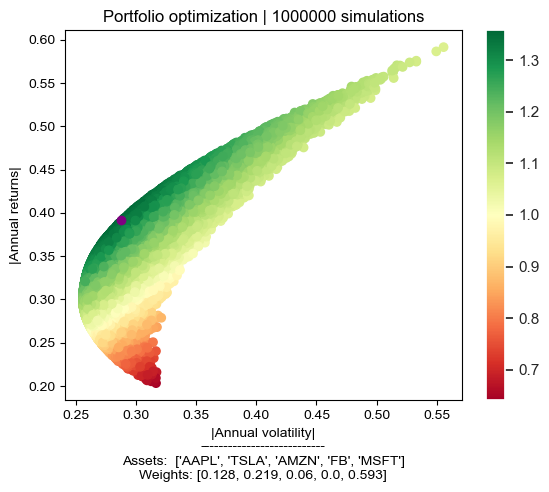

In [8]:
simul = 1000000
port = portfolios_simulations(log_ret,tickers,simul)
max_sharpe = port[port['Sharpe'] == port['Sharpe'].max()]
fig = plot_portfolios(port,max_sharpe,tickers)